In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,9)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')
from datetime import timedelta

In [2]:
df = pd.read_csv('HUElec.csv')
GTWYElec = pd.melt(df, id_vars=["Date"], var_name='time')
GTWYElec['time'] = pd.to_timedelta(GTWYElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
GTWYElec['Date'] = pd.to_datetime(GTWYElec['Date'], format="%m/%d/%Y")
GTWYElec['Datetime'] = GTWYElec['Date'] + GTWYElec['time']
GTWYElec = GTWYElec.set_index('Datetime')
GTWYElec = GTWYElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
GTWYElec.head(100)

,value
Datetime,
2010-01-25 00:00:00,0.000
2010-01-25 00:30:00,0.000
2010-01-25 01:00:00,0.000
2010-01-25 01:30:00,0.000
2010-01-25 02:00:00,0.000
...,...
2010-01-26 23:30:00,39.410
2010-01-27 00:00:00,40.800
2010-01-27 00:30:00,39.213


## Monthly Predictions

In [3]:
def preprocess_data(df):
    df.sort_index()
    df = df.groupby(df.index).first()

    df = df.resample(rule="D").sum()

    return df

monthly_data = preprocess_data(GTWYElec)
monthly_data.index

DatetimeIndex(['2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28',
               '2010-01-29', '2010-01-30', '2010-01-31', '2010-02-01',
               '2010-02-02', '2010-02-03',
               ...
               '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27',
               '2022-02-28', '2022-03-01'],
              dtype='datetime64[ns]', name='Datetime', length=4419, freq='D')

<AxesSubplot:xlabel='Datetime'>

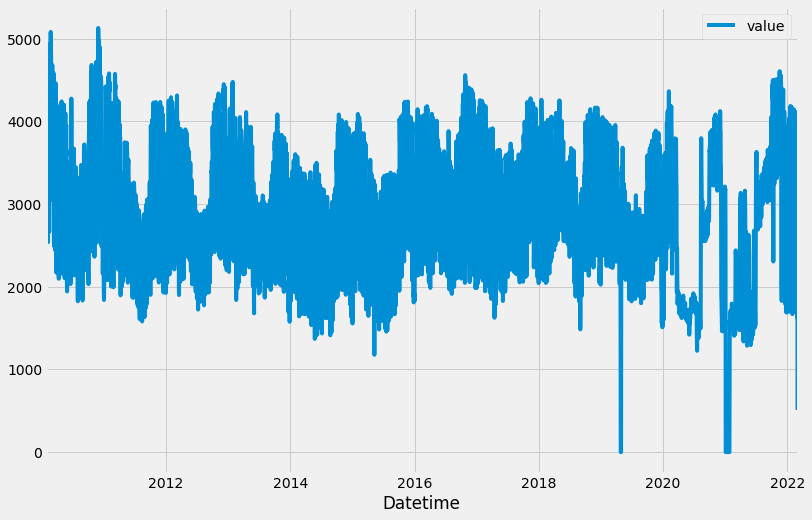

In [4]:
monthly_data.plot(figsize=(12,8))

In [5]:
monthly_data.head()

,value
Datetime,
2010-01-25,3621.456
2010-01-26,4446.840
2010-01-27,4123.918
2010-01-28,4614.666
2010-01-29,4418.075


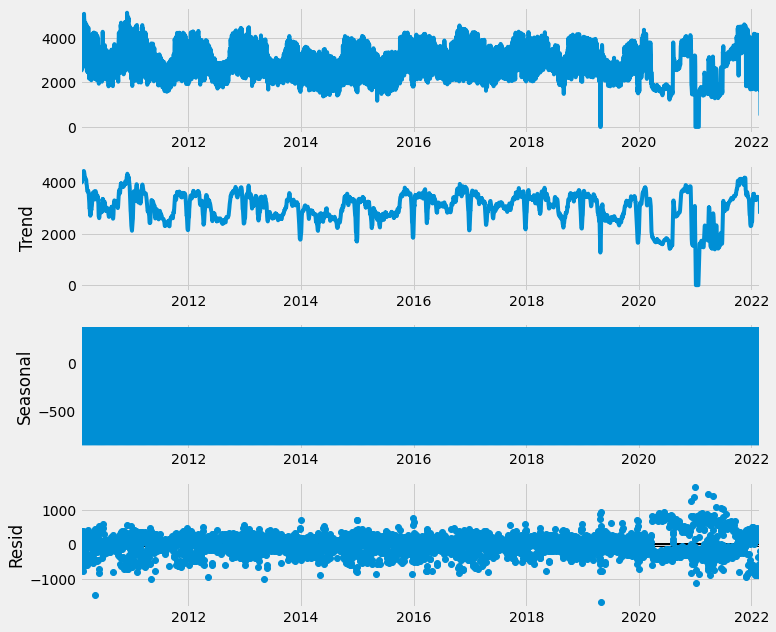

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(monthly_data)
fig = results.plot()

In [7]:
len(monthly_data)

4419

In [8]:
train = monthly_data.iloc[:4054]
test = monthly_data.iloc[4054:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
monthly_data.head(), monthly_data.tail()

(               value
 Datetime            
 2010-01-25  3621.456
 2010-01-26  4446.840
 2010-01-27  4123.918
 2010-01-28  4614.666
 2010-01-29  4418.075,
              value
 Datetime          
 2022-02-25  3794.0
 2022-02-26  1894.0
 2022-02-27  1626.0
 2022-02-28  3679.0
 2022-03-01   509.0)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.70600276],
       [0.86691135],
       [0.80395772],
       [0.89962903],
       [0.86130362],
       [0.65909   ],
       [0.60856579],
       [0.96234541],
       [0.95086286],
       [0.92495186]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.70600276 0.86691135 0.80395772 0.89962903 0.86130362 0.65909
 0.60856579 0.96234541 0.95086286 0.92495186 0.91608651 0.82083298
 0.51995615 0.49501523 0.87742286 0.91847523 0.91039534 0.94427062
 0.87371608 0.51882622 0.5199622  0.94892778 0.93916527 0.9315246
 0.95404542 0.89671453 0.69284091 0.61242288 0.98819305 0.99061452]
Predict this y: 
[[0.93979438]]


In [15]:
X.shape

(1, 30, 1)

In [16]:
# We do the same thing, but now instead for 12 months
n_input = 30
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

In [18]:
# Define model
# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dense(1))
# model.compile(optimizer= 'adam', loss='mse')

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit model
model.fit(generator, epochs=10)

Epoch 1/10
4024/4024 [==============================] - 48s 11ms/step - loss: 0.0257
Epoch 2/10
4024/4024 [==============================] - 44s 11ms/step - loss: 0.0187
Epoch 3/10
4024/4024 [==============================] - 44s 11ms/step - loss: 0.0142
Epoch 4/10
4024/4024 [==============================] - 46s 11ms/step - loss: 0.0095
Epoch 5/10
4024/4024 [==============================] - 47s 12ms/step - loss: 0.0056
Epoch 6/10
4024/4024 [==============================] - 49s 12ms/step - loss: 0.0046
Epoch 7/10
4024/4024 [==============================] - 52s 13ms/step - loss: 0.0041
Epoch 8/10
4024/4024 [==============================] - 51s 13ms/step - loss: 0.0040
Epoch 9/10
4024/4024 [==============================] - 50s 12ms/step - loss: 0.0038
Epoch 10/10
4024/4024 [==============================] - 50s 12ms/step - loss: 0.0036


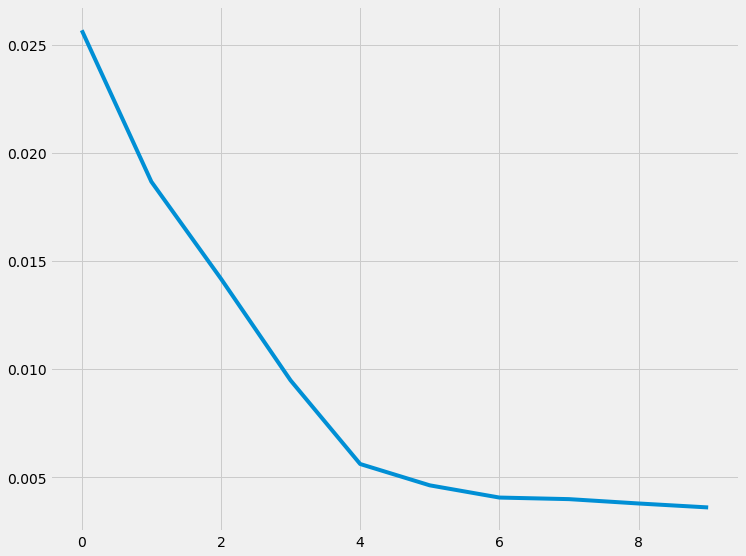

In [21]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [22]:
last_train_batch = scaled_train[-30:]

In [23]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [24]:
model.predict(last_train_batch)

array([[0.42526725]], dtype=float32)

In [25]:
scaled_test[0]

array([0.47509309])

In [26]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # Append the prediction into array
    test_predictions.append(current_pred)

    # Use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [27]:
test_predictions[:5]

[array([0.42526725], dtype=float32),
 array([0.41026047], dtype=float32),
 array([0.38298607], dtype=float32),
 array([0.35984838], dtype=float32),
 array([0.39545497], dtype=float32)]

In [28]:
true_pred = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_pred

<ipython-input-29-0dfcba9b5a0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


In [30]:
test.head()

,value,Predictions
Datetime,,
2021-03-02,2437.000,2181.417286
2021-03-03,2440.000,2104.439690
2021-03-04,2357.000,1964.535082
2021-03-05,2328.001,1845.849822
2021-03-06,2288.500,2028.494588


<AxesSubplot:xlabel='Datetime'>

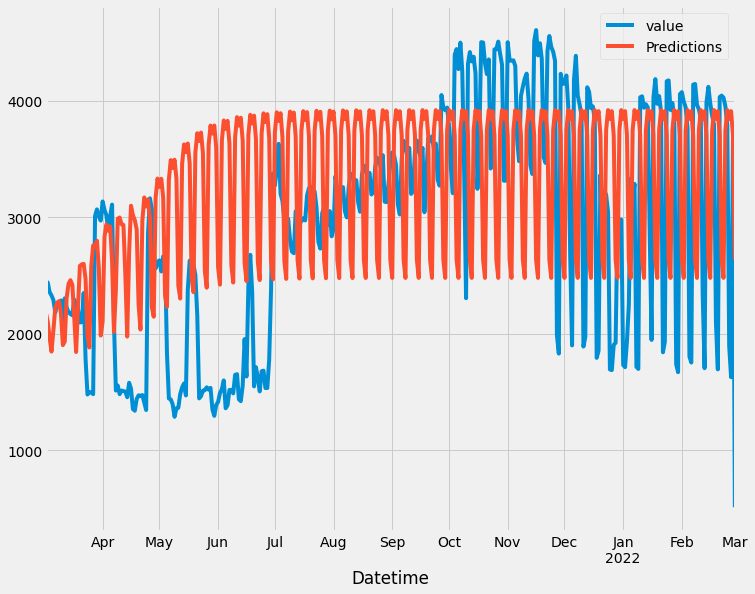

In [31]:
test.plot()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import *

rmse = sqrt(mean_squared_error(test['value'], test['Predictions']))
rmse

1461.717446004836